## Reproduce the results of Figure 8

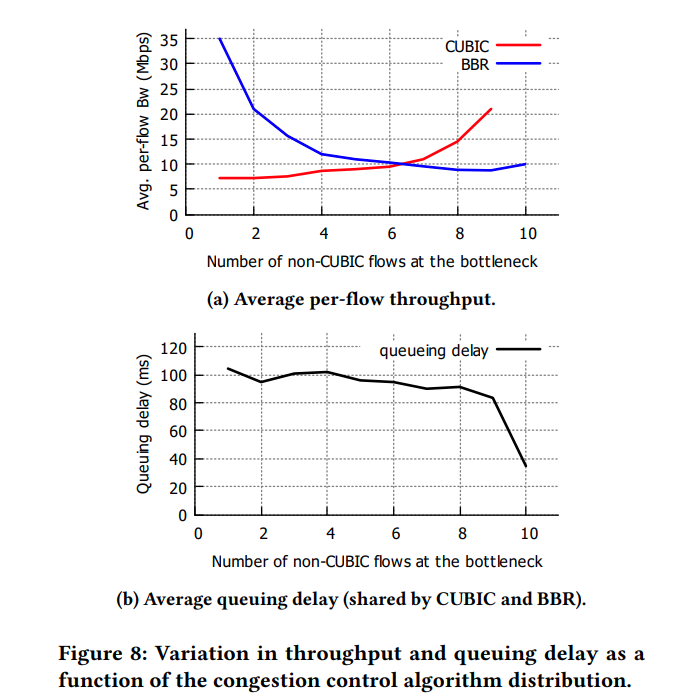

In [15]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
fablib.show_config()

-----------------------------------  --------------------------------------------------
credmgr_host                         cm.fabric-testbed.net
orchestrator_host                    orchestrator.fabric-testbed.net
fabric_token                         /home/fabric/.tokens.json
project_id                           073ee843-2310-45bd-a01f-a15d808827dc
bastion_username                     ashusri_0000051121
bastion_key_filename                 /home/fabric/work/fabric_config/fabric_bastion_key
bastion_public_addr                  bastion-2.fabric-testbed.net
bastion_passphrase                   None
slice_public_key_file                /home/fabric/work/fabric_config/slice_key.pub
slice_private_key_file               /home/fabric/work/fabric_config/slice_key
fabric_slice_private_key_passphrase  None
fablib_log_file                      /tmp/fablib/fablib.log
fablib_log_level                     INFO
-----------------------------------  --------------------------------------------------


In [16]:
!chmod 600 /home/fabric/work/fabric_config/fabric_bastion_key
!chmod 600 /home/fabric/work/fabric_config/slice_key

In [3]:
!echo $FABRIC_TOKEN_LOCATION

/home/fabric/.tokens.json


In [17]:
slice_name="bbr-dominance-line"
slice = fablib.get_slice(slice_name)

In [18]:
for node in slice.get_nodes():
    print(f"{node}")

-----------------  ----------------------------------------------------------------------------------------------------------------------------------------------
ID                 66804ea9-e139-45e0-9ca8-92c7cc3d9c60
Name               client
Cores              4
RAM                32
Disk               100
Image              default_ubuntu_20
Image Type         qcow2
Host               utah-w2.fabric-testbed.net
Site               UTAH
Management IP      2001:1948:417:7:f816:3eff:fe75:67ea
Reservation State  Active
Error Message
SSH Command        ssh -i /home/fabric/work/fabric_config/slice_key -J ashusri_0000051121@bastion-2.fabric-testbed.net ubuntu@2001:1948:417:7:f816:3eff:fe75:67ea
-----------------  ----------------------------------------------------------------------------------------------------------------------------------------------
-----------------  ------------------------------------------------------------------------------------------------------------------------

### Experiment configuration

In [19]:
btl_capacity = 100 # mbit
base_owd     = 20  # ms, to be applied in each direction
n_bdp        = 2
btl_limit    = int(1000*n_bdp*btl_capacity*2*base_owd/8)

### Configure network

Set up bottleneck at router:

In [20]:
btl = [
    {"name": "router", "if": "router-rtr-server_router-p1"}
]    
for b in btl:
    os_if_name = slice.get_interface(name=b['if']).get_os_interface()
    cmds = '''
    sudo tc qdisc del dev {iface} root
    sudo tc qdisc replace dev {iface} root handle 1: htb default 3 
    sudo tc class add dev {iface} parent 1: classid 1:3 htb rate {capacity}mbit 
    sudo tc qdisc add dev {iface} parent 1:3 handle 3: bfifo limit {buffer} 
    '''.format(iface=os_if_name, capacity=btl_capacity, buffer=btl_limit)
    slice.get_node(name=b["name"]).execute(cmds)

Set up delay at emulator:

In [21]:
em = [
    {"name": "emulator", "if": "emulator-client-em_emulator-p1"},
    {"name": "emulator", "if": "emulator-em-rtr_emulator-p1"}
]    
for e in em:
    os_if_name = slice.get_interface(name=e['if']).get_os_interface()
    cmds = "sudo tc qdisc replace dev {iface} root netem delay {owd}ms limit 60000".format(iface=os_if_name, owd=base_owd, buffer=btl_limit)
    slice.get_node(name=e["name"]).execute(cmds)

In [22]:
slice.get_node(name="client").execute("sudo modprobe tcp_bbr")

('', '')

### Iterate over number of BBR flows

In [24]:
import time

d = 200
slice.get_node(name="server").execute("killall iperf3")
os_if_name = slice.get_interface(name="router-rtr-server_router-p1").get_os_interface()
router_script="rm queue-{expid}.txt; start_time=$(date +%s); while true; do tc -p -s -d qdisc show dev ens8 | tr -d '\n' | ts '%.s' | tee -a queue-{expid}.txt; echo "" | tee -a queue-{expid}.txt; current_time=$(date +%s); elapsed_time=$((current_time - start_time));  if [ $elapsed_time -ge {duration} ]; then break; fi; sleep 0.1; done;"

ss_script="rm -f {expid}-ss.txt; start_time=$(date +%s); while true; do ss --no-header -eipn dst 10.0.3.1 | ts '%.s' | tee -a {expid}-ss.txt; current_time=$(date +%s); elapsed_time=$((current_time - start_time));  if [ $elapsed_time -ge {duration} ]; then break; fi; sleep 0.1; done;"


for i in range(1, 11):
    print("Staring experiment with {flows} BBR flows, for {duration} seconds".format(flows=i, duration=d))
    # start BBR and non-BBR server instance
    slice.get_node(name="server").execute("iperf3 -s -1 -p 4000 -D")
    slice.get_node(name="server").execute("iperf3 -s -1 -p 5000 -D")
    slice.get_node(name="router").execute_thread(router_script.format(expid=i, iface=os_if_name, duration=d))
    slice.get_node(name="client").execute_thread(ss_script.format(expid=i, duration=d))
    slice.get_node(name="client").execute_thread("sleep 1; iperf3 -c 10.0.3.1 -t {duration} -P {flows} -C bbr -p 4000 -J > bbr-result-{expid}.json".format(duration=d, flows=i, expid=i))
    stdout, stderr = slice.get_node(name="client").execute("sleep 1; iperf3 -c 10.0.3.1 -t {duration} -P {flows} -C cubic -p 5000 -i 0.1 -J > cubic-result-{expid}.json".format(duration=d, flows=10-i, expid=i))
    time.sleep(5)
    


Staring experiment with 1 BBR flows, for 200 seconds
Staring experiment with 2 BBR flows, for 200 seconds
Staring experiment with 3 BBR flows, for 200 seconds
Staring experiment with 4 BBR flows, for 200 seconds
Staring experiment with 5 BBR flows, for 200 seconds
Staring experiment with 6 BBR flows, for 200 seconds
Staring experiment with 7 BBR flows, for 200 seconds
Staring experiment with 8 BBR flows, for 200 seconds
Staring experiment with 9 BBR flows, for 200 seconds
Staring experiment with 10 BBR flows, for 200 seconds


#### Download experiment data from the FABRIC nodes to your local directory on JupyterHub

In [26]:
for i in range(1, 11):
    
    slice.get_node(name="client").download_file("/home/fabric/work/cnert_bbr_project/figure_8_results/100Mbps,40ms/bbr-result-{expid}.json".format(expid=i),"/home/ubuntu/bbr-result-{expid}.json".format(expid=i))
    slice.get_node(name="client").download_file("/home/fabric/work/cnert_bbr_project/figure_8_results/100Mbps,40ms/cubic-result-{expid}.json".format(expid=i),"/home/ubuntu/cubic-result-{expid}.json".format(expid=i))
    slice.get_node(name="router").download_file("/home/fabric/work/cnert_bbr_project/figure_8_results/100Mbps,40ms/queue-{expid}.txt".format(expid=i),"/home/ubuntu/queue-{expid}.txt".format(expid=i))
    slice.get_node(name="router").execute("cat queue-{expid}.txt | awk '{{print $1\",\"$24$30\",\"$31}}' | tr -d 'b' | tr -d 'p' | sed 's/K/000/' | sed 's/M/000000/' > queue-{expid}.csv".format(expid=i))
    slice.get_node(name="router").download_file("/home/fabric/work/cnert_bbr_project/figure_8_results/100Mbps,40ms/queue-{expid}.csv".format(expid=i),"/home/ubuntu/queue-{expid}.csv".format(expid=i))

### Analyze data and generate plot

1
2
3
4
5
6
7
8
9


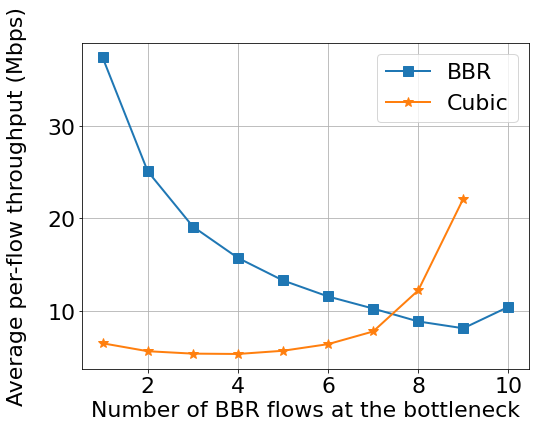

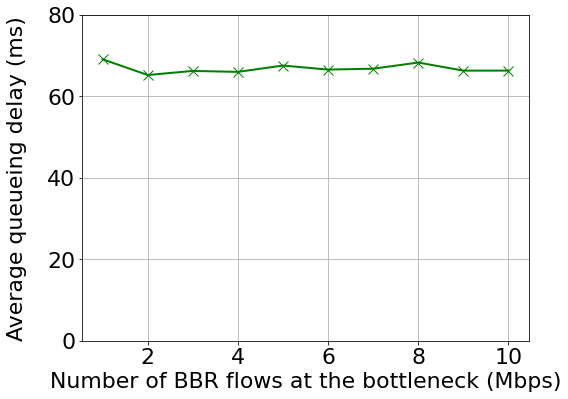

In [20]:
btl_capacity = 100 # mbit
base_owd     = 20  # ms, to be applied in each direction
n_bdp        = 2
btl_limit    = int(1000*n_bdp*btl_capacity*2*base_owd/8)

import json

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

scenario ='100Mbps,40ms' # specify network scenario

per_flow_throughput_bbr = np.zeros(10)
per_flow_throughput_cubic = np.zeros(9)
average_queue_delay = np.zeros(10)


for i in range(1,10):
    # Load the JSON output file into a Python object
    with open("figure_8_results/{scenario}/bbr-result-{expid}.json".format(expid=i, scenario=scenario), "r") as f:
        iperf3_data = json.load(f)


    per_flow_throughput_bbr[i-1] = iperf3_data['end']['sum_received']['bits_per_second']/(1000000*i)
    #print(f"per_flow_throughput_bbr-{i}: {iperf3_data['end']['sum_received']['bits_per_second']/(1000000*i)} Mbps")
    
    with open("figure_8_results/{scenario}/cubic-result-{expid}.json".format(expid=i, scenario=scenario), "r") as f:
        iperf3_data = json.load(f)
    #print(f"per_flow_throughput_cubic-{i}: {iperf3_data['end']['sum_received']['bits_per_second']/(1000000*i)} Mbps")

    per_flow_throughput_cubic[i-1] = iperf3_data['end']['sum_received']['bits_per_second']/(1000000*(10-i))
    
    print(i)
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv("figure_8_results/{scenario}/queue-{expid}.csv".format(expid=i, scenario=scenario), header=None, names=["timestamp", "c2","backlog","c4"])

    average_queue_delay[i-1] = (df["backlog"].mean()*8)/(btl_capacity*1000)
    
with open("figure_8_results/{scenario}/bbr-result-{expid}.json".format(expid=10, scenario=scenario), "r") as f:
     iperf3_data = json.load(f)


per_flow_throughput_bbr[i] = iperf3_data['end']['sum_received']['bits_per_second']/(1000000*i)

df = pd.read_csv("figure_8_results/{scenario}/queue-{expid}.csv".format(expid=i, scenario=scenario), header=None, names=["timestamp", "c2","backlog","c4"])

average_queue_delay[i] = (df["backlog"].mean()*8)/(btl_capacity*1000)

plt.rcParams.update({'font.size': 22})

fontsize=22

linewidth=2.0

labelsize=22

markersize = 10


x1 = np.arange(1, 11)
x2 = np.arange(1, 10)
# Create the figure with a specific size
fig, ax = plt.subplots(figsize=(8,6))

# Plot the data
ax.plot(x1, per_flow_throughput_bbr, label='BBR', linewidth=linewidth, marker ='s', markersize=10)
ax.plot(x2, per_flow_throughput_cubic, label='Cubic', linewidth=linewidth, marker ='*', markersize=10)

# Set the font size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=labelsize)

# Set the x-axis and y-axis labels
ax.set_xlabel('Number of BBR flows at the bottleneck', fontsize=fontsize)
ax.set_ylabel('Average per-flow throughput (Mbps)', fontsize=fontsize, labelpad=20)

# Leave a gap between the y-axis label and the tick labels
#ax.yaxis.set_label_coords(-0.1, 0.5, transform=ax.transAxes, labelpad=20)

# Add a legend
ax.legend(fontsize=fontsize)

# Add grid lines
ax.grid()


plt.savefig('figure_8a.pdf')


# Create the figure with a specific size
fig, ax = plt.subplots(figsize=(8,6))

x1 = np.arange(1, 11)
ax.plot(x1, average_queue_delay, linewidth=linewidth, marker ='x', markersize=10, color = "green",  )
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.set_xlabel('Number of BBR flows at the bottleneck (Mbps)', fontsize=fontsize)
ax.set_ylabel('Average queueing delay (ms)', fontsize=fontsize,  labelpad=20)
plt.ylim(0, 80)
ax.grid()


plt.savefig('figure_8b.pdf')